In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
train = pd.read_csv('/Users/cenkerarin/ml_test/datasets/cs-training.csv')
test = pd.read_csv('/Users/cenkerarin/ml_test/datasets/cs-test.csv')

In [4]:
X = train.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = train['SeriousDlqin2yrs']

X = X.fillna(X.median())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---


 **LightGBM Önemli Parametreleri:**
 
 ### Temel Parametreler
 - **objective**: Modelin çözeceği problem türü ('binary' - ikili sınıflandırma)
 - **metric**: Modelin performansını değerlendirmek için kullanılan metrik
 - **boosting_type**: Boosting algoritması türü (gbdt: Gradient Boosting Decision Tree)
 
 ### Ağaç Yapısı Parametreleri
 - **num_leaves**: Her ağaçtaki maksimum yaprak sayısı. Çok yüksek değerler overfitting'e neden olabilir
 - **max_depth**: Ağaçların maksimum derinliği. -1 değeri sınırsız derinlik anlamına gelir 
 - **min_data_in_leaf**: Her yaprakta bulunması gereken minimum veri sayısı. Overfitting'i önler
 
 ### Öğrenme Parametreleri
 - **learning_rate**: Her boosting adımında katkının ne kadarının kullanılacağını belirler
 - **max_bin**: Özellik değerlerinin kaç bin'e ayrılacağını belirler. Yüksek değerler daha iyi doğruluk ancak daha yavaş eğitim
 
 ### Regularizasyon Parametreleri
 - **lambda_l1**: L1 regularizasyon parametresi. Özellik seçiminde yardımcı olur
 - **lambda_l2**: L2 regularizasyon parametresi. Overfitting'i önler
 - **feature_fraction**: Her iterasyonda rastgele seçilecek özellik oranı (0.9 = %90)
 
 ### Bagging Parametreleri
 - **bagging_fraction**: Her iterasyonda kullanılacak veri oranı. Overfitting'i azaltır
 - **bagging_freq**: Kaç iterasyonda bir bagging uygulanacağı


In [7]:
# LightGBM model oluşturma ve eğitme
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# LightGBM parametreleri - Kapsamlı parametre seti
params = {
    # Temel parametreler
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',  # 'gbdt', 'dart', 'goss', 'rf'
    'random_state': 42,
    'verbosity': 0,
    
    # Ağaç yapısı parametreleri
    'num_leaves': 31,          # Maksimum yaprak sayısı
    'max_depth': -1,           # Maksimum derinlik (-1: sınırsız)
    'min_data_in_leaf': 20,    # Yaprakta minimum veri sayısı
    'min_sum_hessian_in_leaf': 1e-3,  # Yaprakta minimum hessian toplamı
    'min_gain_to_split': 0.0,  # Bölünme için minimum kazanç
    
    # Öğrenme parametreleri
    'learning_rate': 0.05,     # Öğrenme oranı
    'max_bin': 255,            # Maksimum bin sayısı
    'bin_construct_sample_cnt': 200000,  # Bin oluşturma için örnek sayısı
    
    # Regularizasyon parametreleri
    'lambda_l1': 0.0,          # L1 regularizasyon
    'lambda_l2': 0.0,          # L2 regularizasyon
    'min_split_gain': 0.0,     # Minimum bölünme kazancı
    'feature_fraction': 0.9,   # Her iterasyonda kullanılacak özellik oranı
    'feature_fraction_bynode': 1.0,  # Her düğümde kullanılacak özellik oranı
    'feature_fraction_seed': 2,     # Özellik seçimi için seed
    
    # Bagging parametreleri
    'bagging_fraction': 0.8,   # Her iterasyonda kullanılacak veri oranı
    'bagging_freq': 5,         # Bagging frekansı
    'bagging_seed': 3,         # Bagging için seed
    
    # Kategorik özellik parametreleri
    'cat_smooth': 10.0,        # Kategorik özellikler için düzgünleştirme
    'cat_l2': 10.0,           # Kategorik özellikler için L2 regularizasyon
    'max_cat_threshold': 32,   # Kategorik özellikler için maksimum eşik
    'min_data_per_group': 100, # Grup başına minimum veri
    'max_cat_to_onehot': 4,   # One-hot encoding için maksimum kategori sayısı
    
    # Network parametreleri (dağıtık eğitim için)
    'num_machines': 1,         # Makine sayısı
    'local_listen_port': 12400, # Dinleme portu
    'time_out': 120,          # Zaman aşımı (dakika)
    'machine_list_filename': '',  # Makine listesi dosyası
    
    # GPU parametreleri (GPU kullanımı için)
    # 'device_type': 'cpu',    # 'cpu' veya 'gpu'
    # 'gpu_platform_id': -1,   # GPU platform ID
    # 'gpu_device_id': -1,     # GPU device ID
    
    # İleri düzey parametreler
    'force_col_wise': False,   # Sütun bazlı histogram oluşturma
    'force_row_wise': False,   # Satır bazlı histogram oluşturma
    'histogram_pool_size': -1, # Histogram havuz boyutu
    'max_conflict_rate': 0.0,  # DART için maksimum çakışma oranı
    'is_unbalance': False,     # Dengesiz veri seti için
    'scale_pos_weight': 1.0,   # Pozitif sınıf ağırlığı
    'boost_from_average': True, # Ortalamadan başlangıç
    'tree_learner': 'serial',  # 'serial', 'feature', 'data', 'voting'
    'num_threads': 0,          # Thread sayısı (0: otomatik)
    'device_type': 'cpu',      # Cihaz tipi
    'seed': 42,                # Genel seed
    
    # DART parametreleri (boosting_type='dart' için)
    'drop_rate': 0.1,          # Dropout oranı
    'max_drop': 50,            # Maksimum drop sayısı
    'skip_drop': 0.5,          # Drop atlama oranı
    'xgboost_dart_mode': False, # XGBoost DART modu
    'uniform_drop': False,     # Uniform drop
    
    # Linear tree parametreleri
    'linear_tree': False,      # Linear tree kullanımı
    'linear_lambda': 0.0,      # Linear tree için regularizasyon
    
    # Diğer önemli parametreler
    'first_metric_only': False,  # Sadece ilk metriği kullan
    'max_delta_step': 0.0,     # Maksimum delta adımı
    'zero_as_missing': False,  # Sıfırı eksik değer olarak kabul et
    'feature_pre_filter': True, # Özellik ön filtreleme
    'monotone_constraints': None, # Monotonluk kısıtlamaları
    'monotone_penalty': 0.0,   # Monotonluk cezası
    'monotone_constraints_method': 'basic', # Monotonluk yöntemi
    'interaction_constraints': None, # Etkileşim kısıtlamaları
}

# Model eğitimi
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'validation'],
    num_boost_round=1000,      # Maksimum iterasyon sayısı
    callbacks=[
        lgb.early_stopping(50),     # Erken durdurma
        lgb.log_evaluation(50),     # Log gösterme frekansı
        lgb.reset_parameter(learning_rate=lambda iter: 0.05 * (0.99 ** iter))  # Dinamik learning rate
    ]
)

[LightGBM] [Warning] Unknown parameter: max_conflict_rate
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] Unknown parameter: max_conflict_rate
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] Unknown parameter: max_conflict_rate
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.177561	validation's binary_logloss: 0.179773
[100]	train's binary_logloss: 0.173379

Accuracy: 0.9376

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.61      0.18      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.78      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000


Confusion Matrix:
[[27766   229]
 [ 1644   361]]


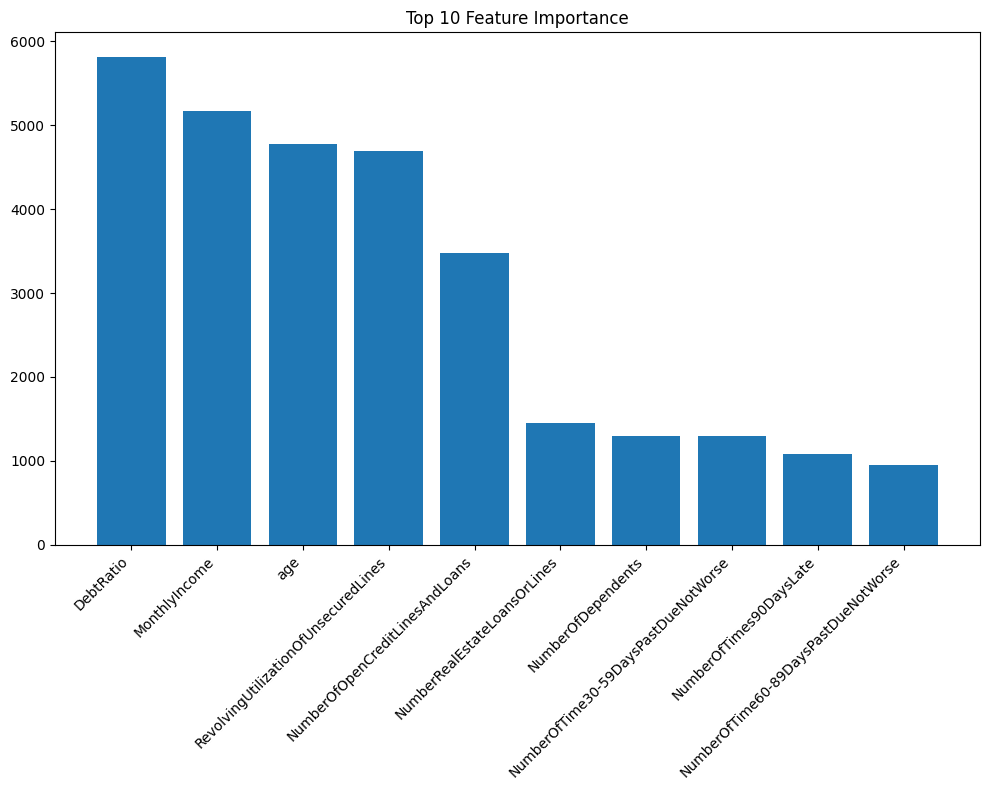

In [8]:
# Tahmin yapma
y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)

# Model değerlendirme
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Feature importance görselleştirme
feature_importance = model.feature_importance(importance_type='split')
feature_names = X_train.columns

plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importance)[::-1][:10]
plt.title("Top 10 Feature Importance")
plt.bar(range(10), feature_importance[indices])
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()